In [2]:
import numpy as np
from pydicom import dcmread
from matplotlib import pyplot as plt
%matplotlib inline
import cv2

import os
wd = os.getcwd()
from zipfile import ZipFile

import sys
sys.path.insert(0,r'C:path\to\Model')

from trig_fund import *
from dambreak import *
from lit_models import *

import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice")

In [16]:
#dicom file info

path_to_download = 'C:/path/to/flywheel/Magma Flow/SUBJECTS/BoyceTest01/SESSIONS/Boyce^Magma Flow/ACQUISITIONS'
rot = True # set to true to flip orientation of image
velocity = 1 #number of velocity encodings
frames = np.arange(4,10) # 0 for all
thresh = 0.003 # minimum magnitude of signal intensity
gateframe = 5 # frame of gate removal (used to calculate time from release)

H = 0.07
phi_gas = 0.05
phi_solid = 0.0
eta_liq = 5000/975
delta_t = 7

windowSize = 3 # size for initial smoothing kernel
sigma_x = 8 # gaussian smoothing in x-direction
sigma_y = 0.05 # gaussian smoothing in y-direction
thresh2 = 130 # rethreshold after smoothing (0,255)

path_mag = 'BEAT_FQ2_n2o10_venc10_2d_5';
path_vel = ['BEAT_FQ2_n2o10_venc10_2d_5_P', 'BEAT_FQ2_n2o10_venc10_2d_5_P_0'];
vel_stretch = [10,10]
vel_dir = ['Along-channel', 'Veritcal']
forward_model = True

x_shift = 18 # position of MRI image left edge with respect to channel back (cm)
y_shift = 0.75 # position of MRI image bottom edge with respect to channel bottom (cm)
t_shift = 0.2 # time before gateframe when gate is actually removed

In [10]:
# temporarily unzip files to local directory
try: 
    os.remove('temp')
except: 
    print('Nothing to delete')

try: 
    os.mkdir('temp')
except: 
    print('Already exists')
comp_mag = path_to_download + '/' + path_mag + '/Files/' + [f.split('.zip')[0] for f in os.listdir(path_to_download + '/' + path_mag + '/Files/') if ('.zip' in f)][0]

with ZipFile(comp_mag + '.zip', 'r') as zf:
    zf.extractall(wd + '/temp/mag')


for i in np.arange(velocity):
    comp_vel = path_to_download + '/' + path_vel[i] + '/Files/' + [f.split('.zip')[0] for f in os.listdir(path_to_download + '/' + path_vel[i] + '/Files/') if ('.zip' in f)][0]

    with ZipFile(comp_vel + '.zip', 'r') as zf:
        zf.extractall(wd + '/temp/vel' + str(i))

if forward_model: 
    # Problem setup
    L = 0.2  # reservoir length in m
    rho = 975*(1-phi_gas) # density in kg/m^3
    g = 9.81   # gravitational acceleration m/s^2
    theta = 0
    
    # Rheology model
    B_solid=2.5
    B_gas=2
    phi_m = 0.65
    C1=75
    C2=7
    phi_c_tauy=0.35
    C3=1.3/1.5
    C4=0.5
    phi_c_n=0.35
    
    K = eta_liq*Birnbaum_Lev_K(phi_solid,phi_gas,phi_m=phi_m,B_solid=B_solid,B_gas=B_gas)
    tauy = Birnbaum_Lev_tauy(phi_solid,phi_gas,phi_c=phi_c_tauy,C1=C1,C2=C2)
    dudz_scale = (H**2*rho*g/K/L)
    Ca = 0.0005*eta_liq*dudz_scale/0.04
    n = Birnbaum_Lev_n(np.array([phi_solid]),phi_gas,Ca,phi_c=phi_c_n,C3=C3,C4=C4)[0]
    
    print('K = ' + '%.2f'%K + ', tau_y = ' + '%.2f'%tauy + ', n = ' + '%.2f'%n)

    # Discretize domain 
    m = 80
    x = np.linspace(0, 0.8, m+2)
    dx = x[1] - x[0]
    z = np.linspace(0,H,40)
    dz = z[1] - z[0]

    i = 100000
    threshold = 0.0001
    
    # Initial condition
    h0 = np.zeros(m+2)
    h0[x<=L] = H

    # Solve
    h, t, Y, u = dambreak_u(x, z, h0, theta, rho, K, tauy, n, g, delta_t, i) # No slope for comparison

    # Strain rate
    dudz = (u[:,:,1:] - u[:,:,:-1])/dz
    
    # mask out above flow area
    zz,xx = np.meshgrid(z,x)
    zz = np.tile(zz,(t.shape[0],1,1))
    hh = np.tile(np.expand_dims(h, axis=2),(1,1,z.shape[0]))
    u[zz[:,1:-1,:]>(hh[:,1:-1,:] - threshold)] = np.nan
    

Nothing to delete
K = 5.68, tau_y = 0.01, n = 1.00


Text(0, 0.5, 'Height (cm)')

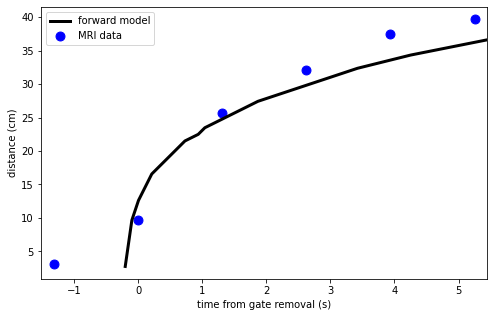

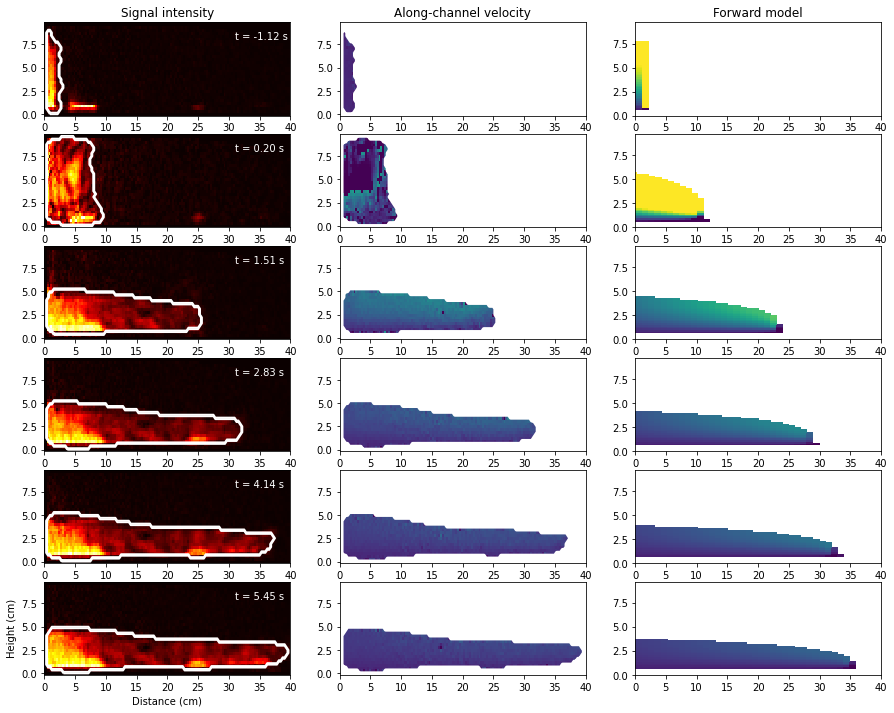

In [17]:
# visualize data
ds = dcmread('temp/mag/' + os.listdir('temp/mag')[0] + '/' + os.listdir('temp/mag/' + os.listdir('temp/mag')[0])[gateframe])
gatetime = ds.AcquisitionTime

if rot:
    mags = np.zeros((frames.size,ds.pixel_array.shape[1], ds.pixel_array.shape[0]))
else: 
    mags = np.zeros((frames.size,ds.pixel_array.shape[0], ds.pixel_array.shape[1]))
masks = np.zeros_like(mags)

if velocity>0: 
    if rot: 
        vels = np.zeros((frames.size,ds.pixel_array.shape[1], ds.pixel_array.shape[0],velocity))
    else:
        vels = np.zeros((frames.size,ds.pixel_array.shape[0], ds.pixel_array.shape[1],velocity))

us = np.zeros((frames.size,u.shape[2],u.shape[1]))

ncols = 1+velocity
if forward_model: 
    ncols += 1
fig,ax = plt.subplots(figsize=(8,5))
fig2,ax2 = plt.subplots(ncols=ncols,nrows=len(frames),figsize=(15,12))

x_front = np.zeros_like(frames, dtype=float)
t_front = np.zeros_like(frames, dtype=float)

for i,j in enumerate(frames):
    ds = dcmread('temp/mag/' + os.listdir('temp/mag')[0] + '/' + os.listdir('temp/mag/' + os.listdir('temp/mag')[0])[j])
    dt = float(ds.AcquisitionTime) - float(gatetime)
    mag = ds.pixel_array.astype(float)
    mag = mag/(2**ds.BitsStored)
    if rot:
        mag = mag.transpose()
    mag = np.flipud(mag)
    height = mag.shape[0]
    
    dx = 40/mag.shape[1]
    x_scale = np.arange(mag.shape[1])*dx
    y_scale = np.arange(mag.shape[0])*dx
    
    mags[i,:,:] = mag
    
    # Read image
    im_mag = np.zeros_like(mag).astype(np.uint8)
    im_mag[mag<thresh] = 255
 
    # Remove low signal regions inside flow
    im_floodfill = im_mag.copy()
    cv2.floodFill(im_floodfill, None, (0, 0), 0)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = im_mag & im_floodfill_inv

    # Remove high signal regions outside flow
    im_floodfill = im_out.copy()
    cv2.floodFill(im_floodfill, None, (2, 10), 255) # select interior point
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    im_out = ~im_out & (~im_floodfill_inv)
    
    # Smooth outline
    
    im_blur = cv2.blur(im_out,(windowSize,windowSize), borderType=0)
    
    if dt>=0:
        im_blur = cv2.GaussianBlur(im_blur,(int(2*np.ceil(2*sigma_x)+1),int(2*np.ceil(2*sigma_y)+1)),sigma_x,sigma_y,
                              borderType=0) 

    # Rethreshold
    mask = im_blur>thresh2
    #mask = np.flipud(mask)
    ax2[i,0].pcolormesh(x_scale, y_scale, mask, shading='auto')
    ax2[i,0].pcolormesh(x_scale, y_scale, mag, cmap=plt.cm.hot, shading='auto')
    cs = ax2[i,0].contour(x_scale, y_scale, mask, levels=1,colors='w',linewidths=2)

    # Get flow outline
    p = cs.collections[0].get_paths()
    c_x = []
    c_y = []
    for p_i in p:
        v = p_i.vertices
        c_x = np.append(c_x, v[:,0])
        c_y = np.append(c_y, v[:,1])
        
    t_front[i] = dt
    x_front[i] = np.max(c_x)
        
    masks[i,:,:] = mask
    
    ax2[0,0].set_title('Signal intensity')
    ax2[i,0].annotate('t = ' + '{:.2f}'.format(dt+t_shift) + ' s',(31,8),color='w')
    ax2[i,0].set_xlim([0,40])
    
    # Plot velocities
    for k in np.arange(velocity):
        ds = dcmread('temp/vel' + str(k) + '/' + os.listdir('temp/vel' + str(k))[0] + '/' + os.listdir(
            'temp/vel' + str(k) + '/'+ os.listdir('temp/vel' + str(k))[0])[j])
        vel = ds.pixel_array.astype(float)
        vel = -vel_stretch[k]*(vel-(2**(ds.BitsStored-1)))/(2**ds.BitsStored-1)
        if rot:
            vel = vel.transpose()
        vel = np.flipud(vel)
        vel[~mask] = np.nan
        
        vels[i,:,:,k] = vel
        
        ax2[0,k+1].set_title(vel_dir[k] + ' velocity')
        ax2[i,k+1].pcolormesh(x_scale, y_scale, vel, cmap=plt.cm.viridis, shading='auto', vmin=-1, vmax=vel_stretch[k])
        ax2[i,k+1].plot(c_x,c_y,'w',linewidth=4)
        ax2[i,k+1].set_xlim([0,40])
        
    # Plot forward model
    if forward_model: 
        ax2[0,velocity+1].set_title('Forward model')
        ax2[i,velocity+1].pcolormesh(100*x[1:-1]-x_shift,100*z+y_shift,100*u[np.argmin(np.abs(t-(dt+t_shift))),:,:].transpose(), 
                             shading='nearest', vmin=-1, vmax=vel_stretch[0])
        ax2[i,velocity+1].set_xlim([0,40])
        ax2[i,velocity+1].set_ylim([0,np.max(y_scale)])
        
        us[i,:,:] = 100*u[np.argmin(np.abs(t-(dt+t_shift))),:,:].transpose()
        
t_pos = np.linspace(0,dt+5,100)
X = np.zeros_like(t_pos)
t_match = np.zeros_like(t_pos)

for j,t_i in enumerate(t_pos):
    X[j] = x[np.max(np.nonzero(h[np.argmin(np.abs(t-t_i)),:]>threshold)) + 1] # find node with h>threshold
    t_match[j] = t[np.argmin(np.abs(t-t_i))]
    ind = np.nonzero(X[1:] - X[:-1])[0]
    model = np.interp(t_match,t_match[ind],X[ind])
    
ax.plot(t_match-t_shift, 100*model-x_shift,'k',linewidth=3,label='forward model')
ax.scatter(t_front,x_front,80,'b',label='MRI data')
ax.set_xlim(np.min(t_front)-0.2, np.max(t_front)+0.2)
ax.set_xlabel('time from gate removal (s)')
ax.set_ylabel('distance (cm)')
ax.legend()

ax2[i,0].set_xlabel('Distance (cm)')
ax2[i,0].set_ylabel('Height (cm)')

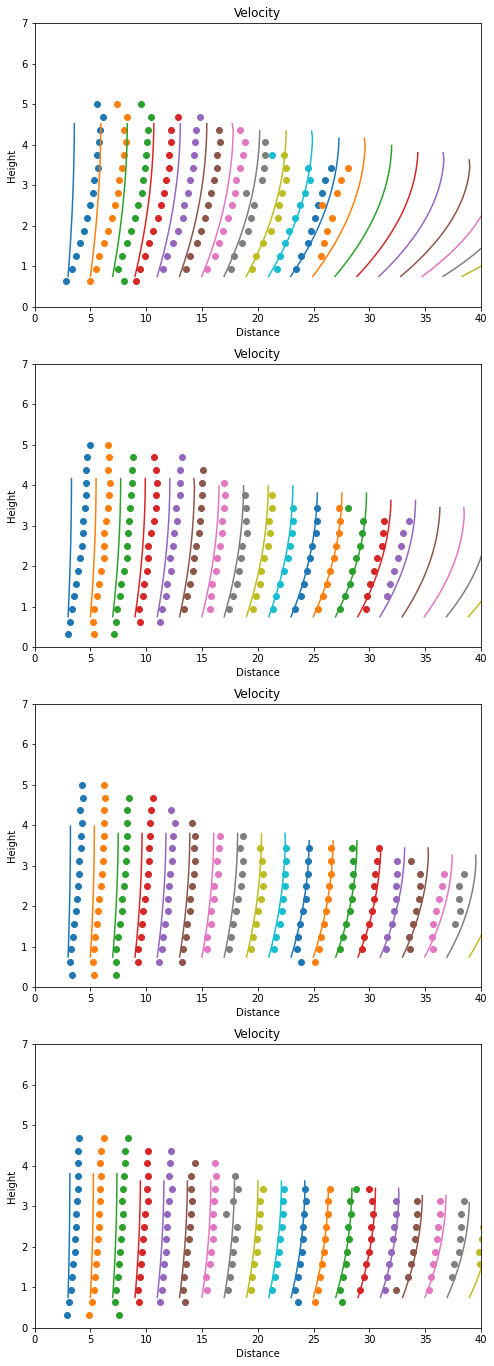

In [29]:
# Plot velocity profiles with depth along flow, spaced out along the x-axis
skip = 2 # frames to skip for plotting velocity profiles
fig,ax = plt.subplots(nrows=frames.size-skip,figsize=(8,24))

x_bin = np.arange(2,42,2)
for i,(vel_i,u_i) in enumerate(zip(vels,us)):
    j = 0
    if i>=skip:
        for m in np.arange(x_bin.size-1):
            ax[i-skip].scatter(np.nanmean(vel_i[:,(x_scale>=x_bin[m]) & (x_scale<x_bin[m+1]),j]+(np.mean(x_bin[m:m+2])),axis=1),y_scale)
            ax[i-skip].plot(np.nanmean(u_i[:,(100*x[1:-1]>=x_bin[m]) & (100*x[1:-1]<x_bin[m+1])]+(np.mean(x_bin[m:m+2])),axis=1),100*z+y_shift)
            ax[i-skip].set_xlim([0, 40])
            ax[i-skip].set_ylim([0,H*100])
            ax[i-skip].set_xlabel('Distance')
            ax[i-skip].set_ylabel('Height')
            ax[i-skip].set_title('Velocity')